In [386]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Customer_Data.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "alicanpayasli/customerdata",file_path)

df = df.drop(columns=['Customer_ID'])

df.head()

C:\Users\vladt\AppData\Local\Temp\ipykernel_19684\1463927112.py:16: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "alicanpayasli/customerdata",file_path)


,Age,Gender,Annual_Income,Spending_Score,Region,Marital_Status,Num_of_Children,Employment_Status,Credit_Score,Online_Shopping_Frequency,Target
0,25,Female,66041,15,South,Widowed,1,Unemployed,332,12,0
1,66,Male,46937,39,South,Single,0,Retired,550,4,0
2,18,Male,142885,65,South,Single,2,Retired,503,7,0
3,19,Female,146383,91,South,Divorced,0,Unemployed,759,9,0
4,57,Male,47686,47,West,Widowed,4,Retired,598,0,0


In [387]:
df.describe()

,Age,Annual_Income,Spending_Score,Num_of_Children,Credit_Score,Online_Shopping_Frequency,Target
count,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,43.444767,85053.84060,49.869967,1.997600,574.002467,9.554500,0.304533
std,14.976284,37674.97408,28.775713,1.410081,158.448319,5.806894,0.460217
min,18.000000,20015.00000,1.000000,0.000000,300.000000,0.000000,0.000000
25%,30.000000,52228.00000,25.000000,1.000000,436.000000,4.000000,0.000000
50%,43.000000,84901.00000,50.000000,2.000000,575.000000,10.000000,0.000000
75%,56.000000,117901.25000,75.000000,3.000000,711.000000,15.000000,1.000000
max,69.000000,149999.00000,99.000000,4.000000,849.000000,19.000000,1.000000


In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        30000 non-null  int64 
 1   Gender                     30000 non-null  object
 2   Annual_Income              30000 non-null  int64 
 3   Spending_Score             30000 non-null  int64 
 4   Region                     30000 non-null  object
 5   Marital_Status             30000 non-null  object
 6   Num_of_Children            30000 non-null  int64 
 7   Employment_Status          30000 non-null  object
 8   Credit_Score               30000 non-null  int64 
 9   Online_Shopping_Frequency  30000 non-null  int64 
 10  Target                     30000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 2.5+ MB


In [389]:
df.isnull().sum()

Age                          0
Gender                       0
Annual_Income                0
Spending_Score               0
Region                       0
Marital_Status               0
Num_of_Children              0
Employment_Status            0
Credit_Score                 0
Online_Shopping_Frequency    0
Target                       0
dtype: int64

C:\Users\vladt\AppData\Local\Temp\ipykernel_19684\2132845740.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df, palette='viridis')


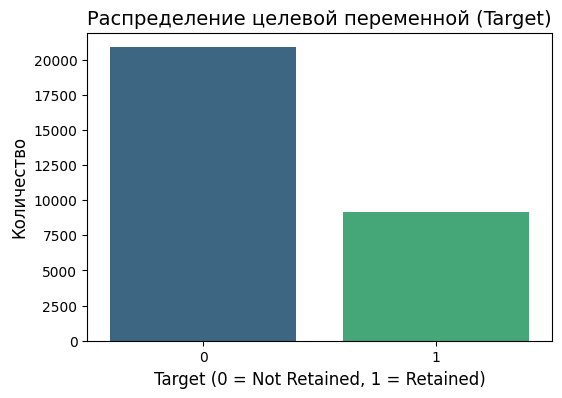

In [390]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Распределение целевой переменной (Target)', fontsize=14)
plt.xlabel('Target (0 = Not Retained, 1 = Retained)', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.show()

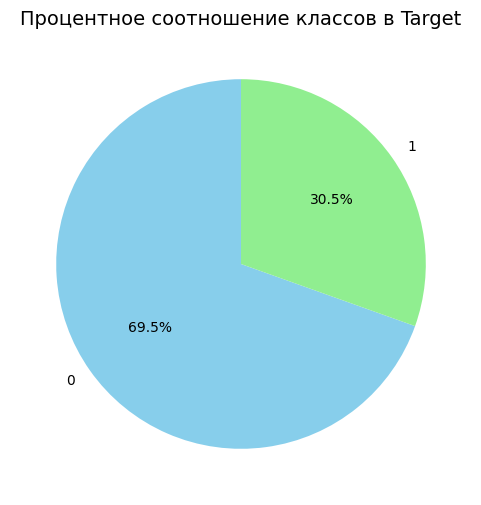

In [391]:
plt.figure(figsize=(6, 6))
df['Target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90)
plt.title('Процентное соотношение классов в Target', fontsize=14)
plt.ylabel('')
plt.show()

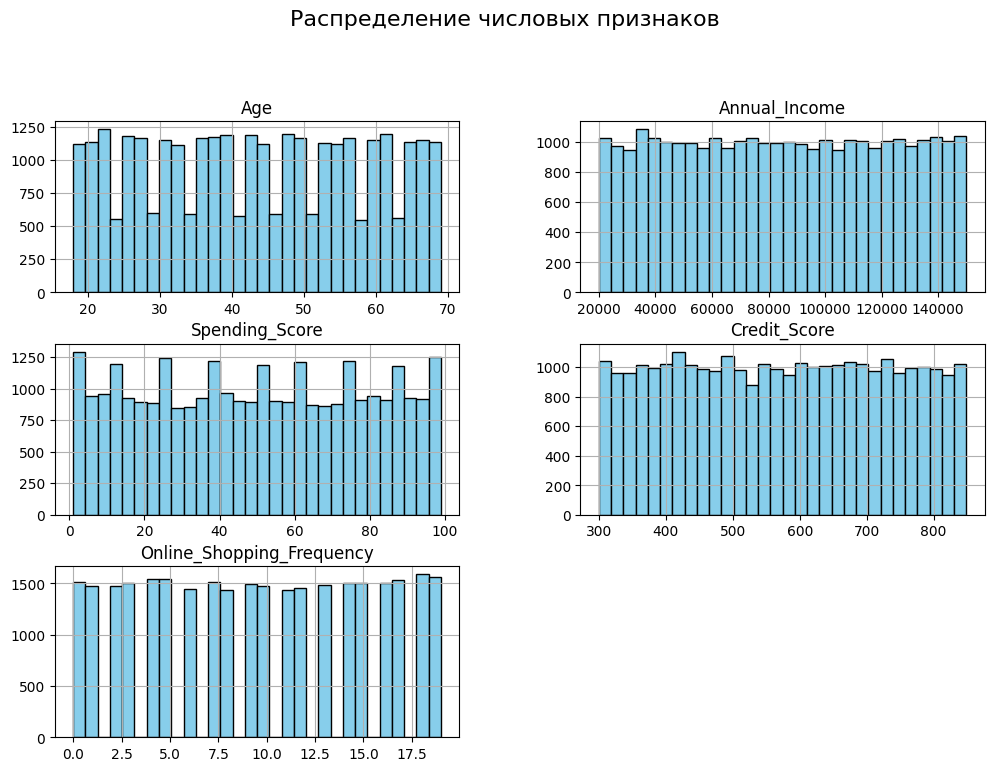

In [392]:
numerical_features = ['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Online_Shopping_Frequency']
df[numerical_features].hist(figsize=(12, 8), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Распределение числовых признаков', fontsize=16, y=1.02)
plt.show()

C:\Users\vladt\AppData\Local\Temp\ipykernel_19684\2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
C:\Users\vladt\AppData\Local\Temp\ipykernel_19684\2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
C:\Users\vladt\AppData\Local\Temp\ipykernel_19684\2050164984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
C:\Users\vladt\AppData\Local\Temp\ipykernel_19684\20501

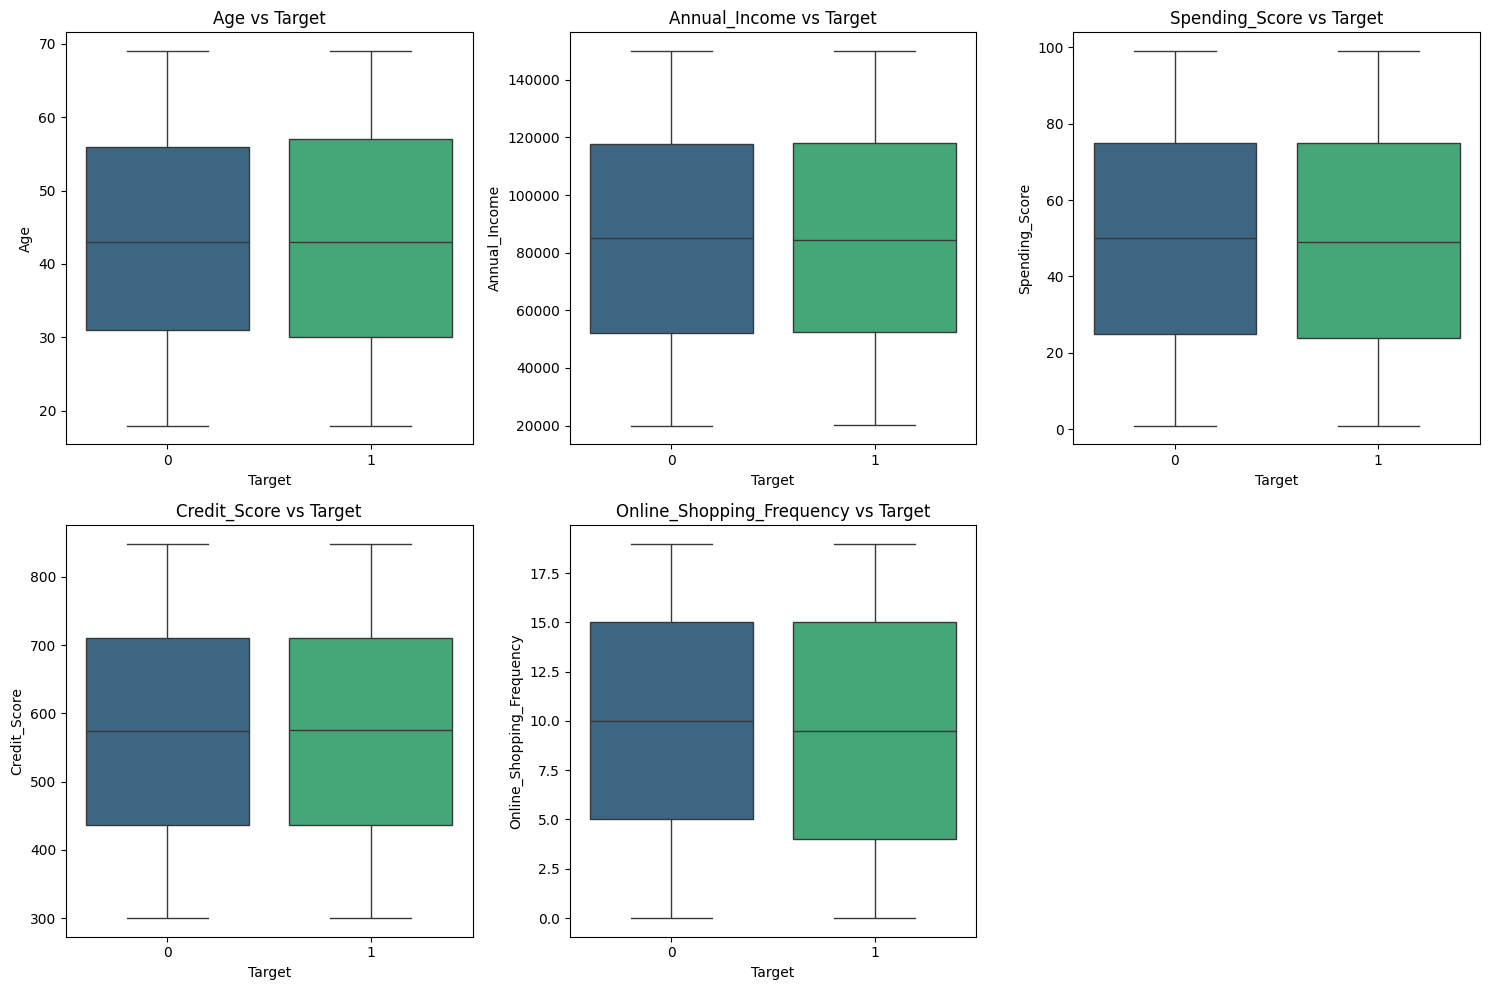

In [393]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Target', y=feature, data=df, palette='viridis')
    plt.title(f'{feature} vs Target', fontsize=12)
    plt.xlabel('Target', fontsize=10)
    plt.ylabel(feature, fontsize=10)
plt.tight_layout()
plt.show()

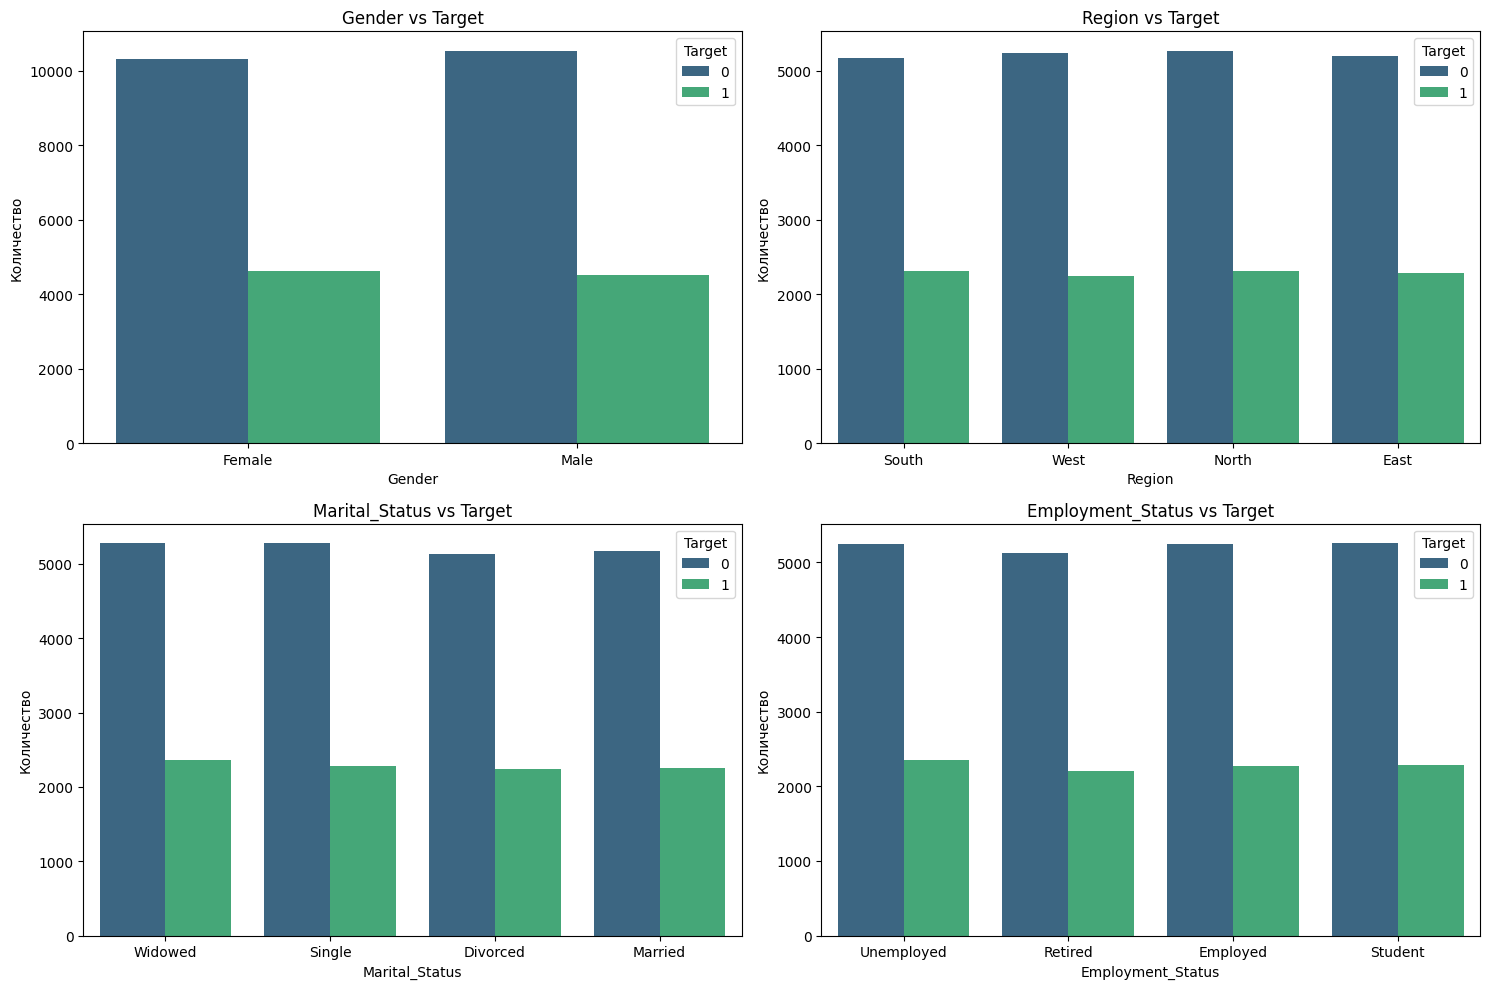

In [394]:
categorical_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, hue='Target', data=df, palette='viridis')
    plt.title(f'{feature} vs Target', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Количество', fontsize=10)
    plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

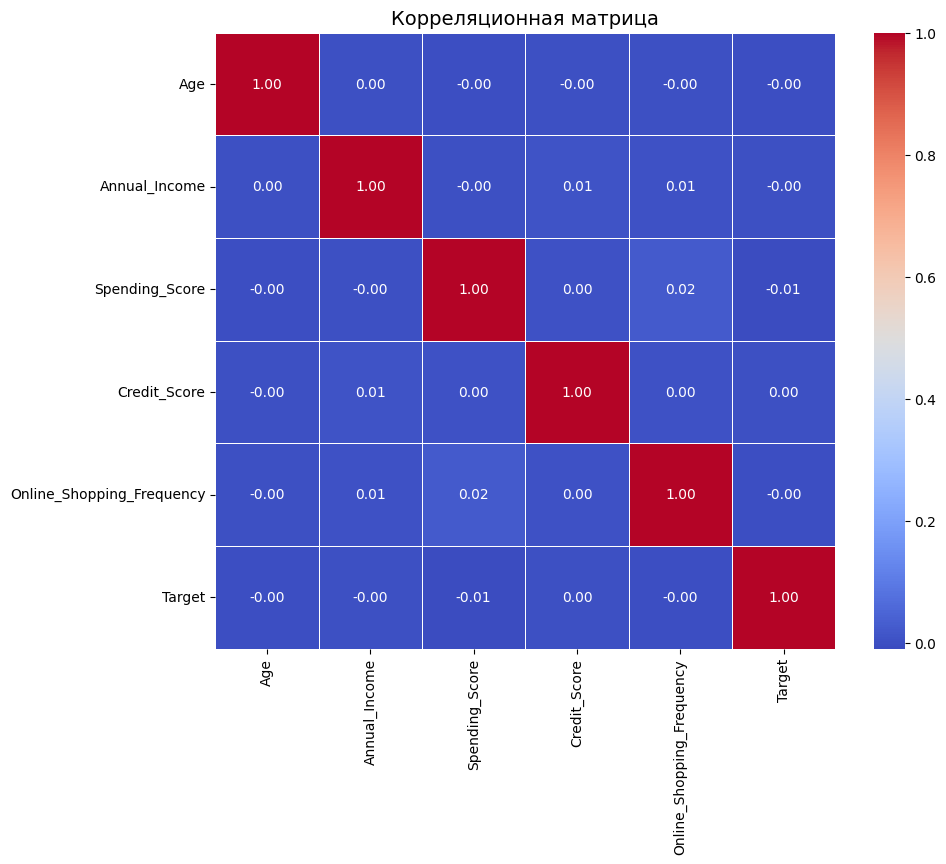

In [395]:
correlation_matrix = df[numerical_features + ['Target']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

In [396]:
# sns.pairplot(df, vars=numerical_features, hue='Target', palette='viridis', diag_kind='kde', height=3)
# plt.suptitle('Pairplot числовых признаков', fontsize=16, y=1.02)
# plt.show()

In [397]:
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(categorical_features, 1):
#     plt.subplot(2, 2, i)
#     sns.violinplot(x=feature, y='Spending_Score', hue='Target', data=df, split=True, palette='viridis')
#     plt.title(f'{feature} vs Spending_Score', fontsize=12)
#     plt.xlabel(feature, fontsize=10)
#     plt.ylabel('Spending_Score', fontsize=10)
# plt.tight_layout()
# plt.show()

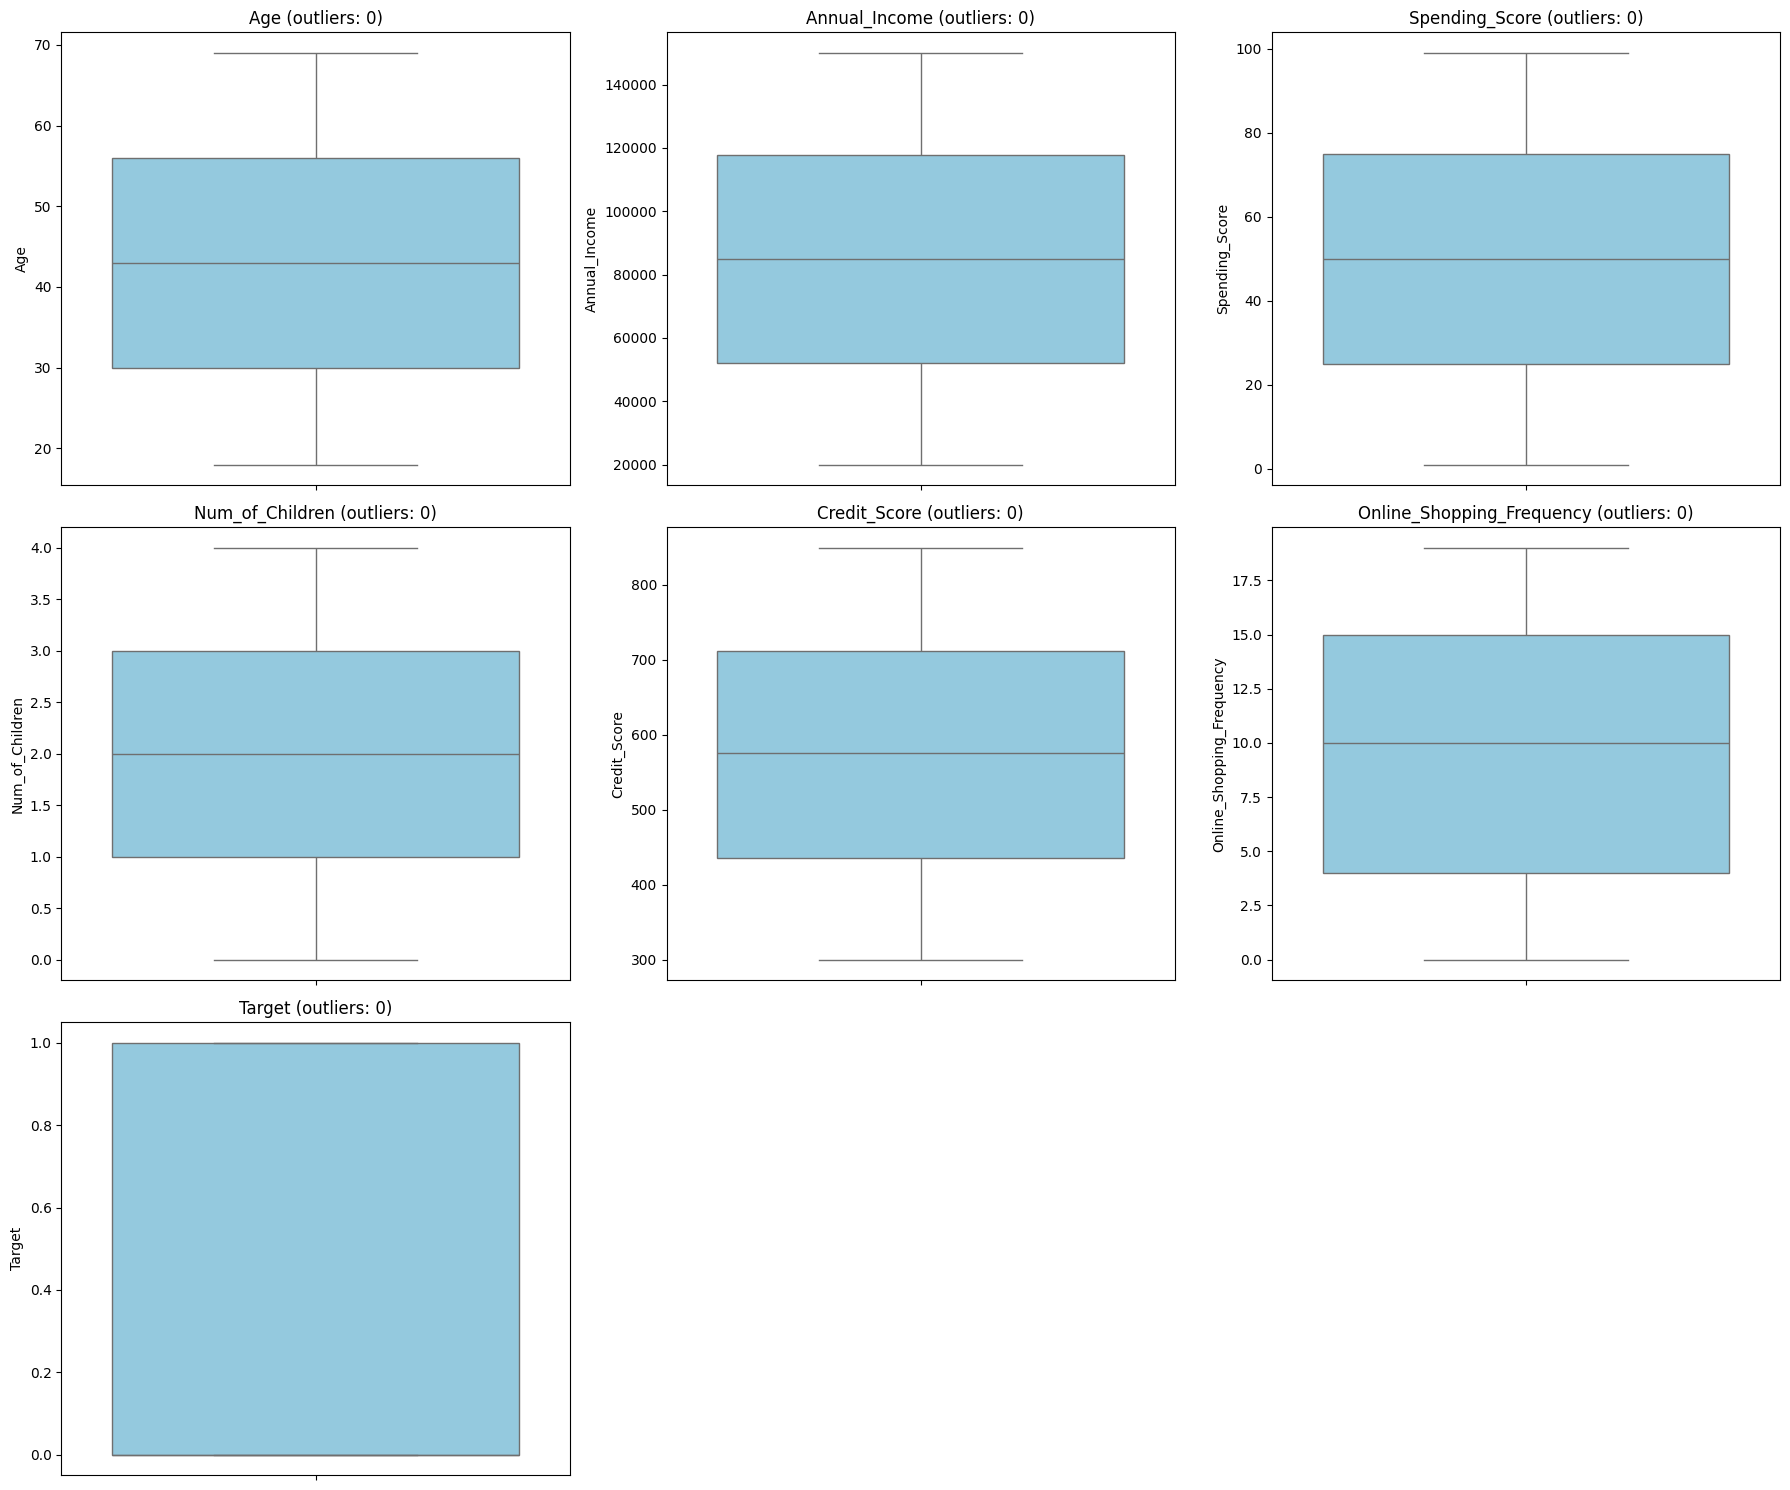

In [ ]:
def detect_and_plot_outliers_iqr(df):
    outliers_summary = {}

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    num_cols = len(numeric_cols)
    ncols = 3
    nrows = (num_cols + ncols - 1) // ncols
    plt.figure(figsize=(6 * ncols, 5 * nrows))

    for i, col in enumerate(numeric_cols, 1):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Найдём выбросы
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_percent = 100 * outlier_count / df.shape[0]

        # Добавим в отчёт
        outliers_summary[col] = {
            'count': outlier_count,
            'percent': round(outlier_percent, 2),
            'indices': outliers.index.tolist()
        }

        # График
        plt.subplot(nrows, ncols, i)
        sns.boxplot(y=df[col], color="skyblue", fliersize=5)
        plt.title(f"{col} (outliers: {outlier_count})")

    plt.tight_layout()
    plt.show()


detect_and_plot_outliers_iqr(df)


In [399]:
# def remove_outliers_iqr(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower) & (df[column] <= upper)]

df_clean = df.copy()

# df_clean = remove_outliers_iqr(df_clean, 'Annual_Income')
# df_clean = remove_outliers_iqr(df_clean, 'Credit_Score')




# df_clean = df_clean[df_clean['Annual_Income'].between(45000, 120000)]
# df_clean = df_clean[df_clean['Credit_Score'].between(400, 750)]

# detect_and_plot_outliers_iqr(df_clean)


In [400]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

numeric_features = ['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Online_Shopping_Frequency']

categorical_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

label_encoders = {}

data = df.copy()

label_encoders = {}
categorical_cols = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop(['Target'], axis=1)
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X = data.drop(columns=['Target'])
y = data['Target']

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      4173
           1       0.36      0.00      0.01      1827

    accuracy                           0.69      6000
   macro avg       0.53      0.50      0.41      6000
weighted avg       0.59      0.69      0.57      6000


Confusion Matrix:
[[4159   14]
 [1819    8]]

ROC-AUC Score: 0.5017712977751649
F1 Score: 0.008653326122228232


In [401]:
df_clean['Spending_to_Income_Ratio'] = df_clean['Spending_Score'] / df_clean['Annual_Income']
df_clean['Age_to_Spending_Ratio'] = df_clean['Age'] / (df_clean['Spending_Score'] + 1)
df_clean['Avg_Spending_Per_Online_Order'] = df_clean['Spending_Score'] / (df_clean['Online_Shopping_Frequency'] + 1)
df_clean['Online_Shopping_Frequency_Per_Age'] = df_clean['Online_Shopping_Frequency'] / df_clean['Age']
df_clean['Log_Annual_Income'] = np.log1p(df_clean['Annual_Income'])
df_clean['Credit_Score_to_Age'] = df_clean['Credit_Score'] / df_clean['Age']

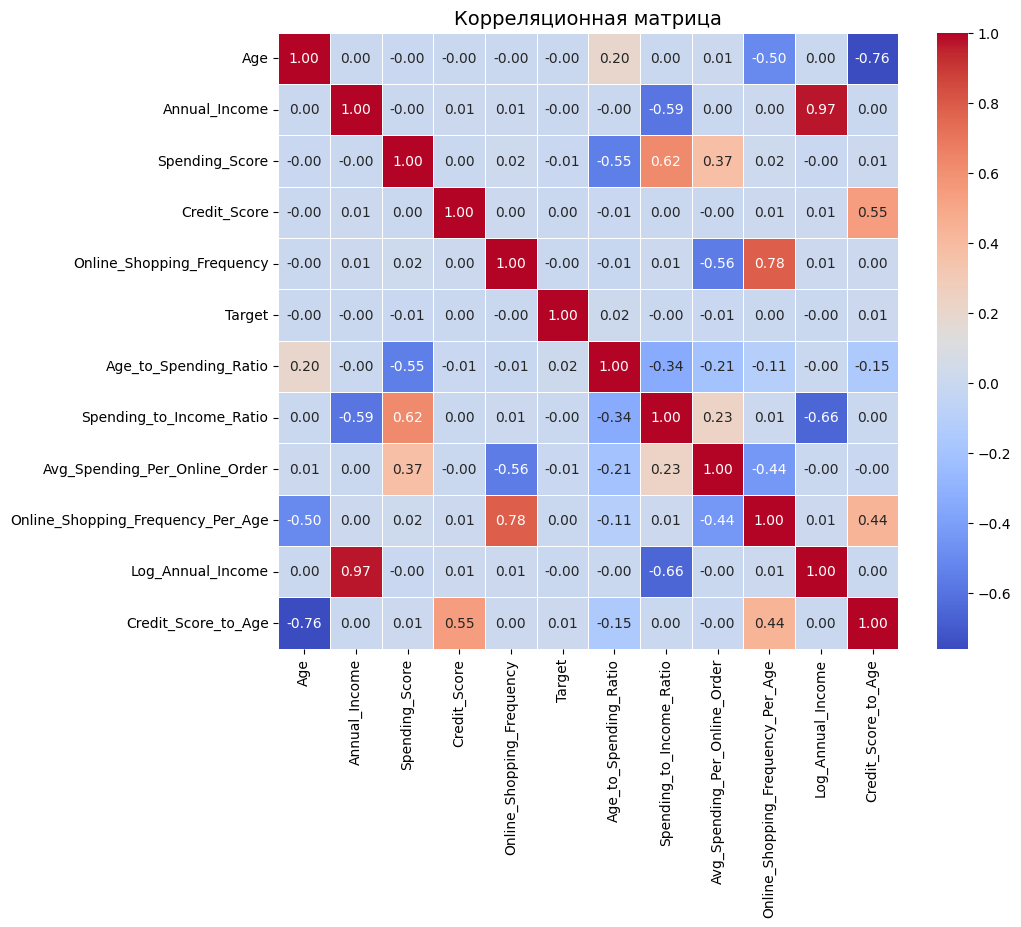

In [ ]:

numerical_features_corr = numerical_features + ['Target' , 'Age_to_Spending_Ratio', 'Spending_to_Income_Ratio', 'Avg_Spending_Per_Online_Order', 'Online_Shopping_Frequency_Per_Age', 'Log_Annual_Income', 'Credit_Score_to_Age']
# numerical_features = numerical_features + ['Target']


correlation_matrix = df_clean[numerical_features_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица', fontsize=14)
plt.show()

In [403]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

numeric_features = ['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Online_Shopping_Frequency']

categorical_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

label_encoders = {}

data = df_clean.copy()

label_encoders = {}
categorical_cols = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop(['Target'], axis=1)
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X = data.drop(columns=['Target'])
y = data['Target']

In [404]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("После SMOTE:", pd.Series(y_train_smote).value_counts())

После SMOTE: Target
0    16691
1    16691
Name: count, dtype: int64


In [405]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_smote, y_train_smote)


y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [406]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      4173
           1       0.30      0.23      0.26      1827

    accuracy                           0.60      6000
   macro avg       0.50      0.50      0.49      6000
weighted avg       0.57      0.60      0.58      6000


Confusion Matrix:
[[3194  979]
 [1411  416]]

ROC-AUC Score: 0.49807556881356435
F1 Score: 0.25822470515207946


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

TARGET_COL = 'Target'

cat_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

X = df.drop([TARGET_COL], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    cat_features=cat_features,
    verbose=50,
    random_seed=42
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

0:	test: 0.5112530	best: 0.5112530 (0)	total: 37.1ms	remaining: 18.5s
50:	test: 0.5035728	best: 0.5112530 (0)	total: 1.87s	remaining: 16.5s
100:	test: 0.5029653	best: 0.5112530 (0)	total: 3.91s	remaining: 15.4s
150:	test: 0.5010276	best: 0.5112530 (0)	total: 6.38s	remaining: 14.7s
200:	test: 0.4978805	best: 0.5112530 (0)	total: 8.73s	remaining: 13s
250:	test: 0.5024478	best: 0.5112530 (0)	total: 11s	remaining: 10.9s
300:	test: 0.4993870	best: 0.5112530 (0)	total: 13.2s	remaining: 8.74s
350:	test: 0.4966301	best: 0.5112530 (0)	total: 15.5s	remaining: 6.59s
400:	test: 0.4949966	best: 0.5112530 (0)	total: 17.8s	remaining: 4.4s
450:	test: 0.4957475	best: 0.5112530 (0)	total: 20.1s	remaining: 2.19s
499:	test: 0.4971257	best: 0.5112530 (0)	total: 22.3s	remaining: 0us

bestTest = 0.5112529776
bestIteration = 0

Shrink model to first 1 iterations.
Confusion Matrix:
[[4173    0]
 [1827    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70 

d:\otus\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\otus\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\otus\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier

TARGET_COL = 'Target'

cat_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']
num_features = [
    'Age',
    'Annual_Income',
    'Spending_Score',
    'Num_of_Children',
    'Credit_Score',
    'Online_Shopping_Frequency'
]

X = df.drop([TARGET_COL], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=50,
    random_seed=42
)

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

0:	total: 28.2ms	remaining: 14.1s
50:	total: 344ms	remaining: 3.03s
100:	total: 660ms	remaining: 2.61s
150:	total: 968ms	remaining: 2.24s
200:	total: 1.28s	remaining: 1.9s
250:	total: 1.65s	remaining: 1.63s
300:	total: 1.97s	remaining: 1.3s
350:	total: 2.28s	remaining: 969ms
400:	total: 2.6s	remaining: 641ms
450:	total: 2.9s	remaining: 315ms
499:	total: 3.2s	remaining: 0us
Confusion Matrix:
[[4102   71]
 [1799   28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.81      4173
           1       0.28      0.02      0.03      1827

    accuracy                           0.69      6000
   macro avg       0.49      0.50      0.42      6000
weighted avg       0.57      0.69      0.58      6000


ROC AUC Score: 0.5112984913178276


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier

TARGET_COL = 'Target'

cat_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']
num_features = [
    'Age',
    'Annual_Income',
    'Spending_Score',
    'Num_of_Children',
    'Credit_Score',
    'Online_Shopping_Frequency'
]

num_features = numerical_features + ['Age_to_Spending_Ratio', 'Spending_to_Income_Ratio', 'Avg_Spending_Per_Online_Order', 'Online_Shopping_Frequency_Per_Age', 'Log_Annual_Income', 'Credit_Score_to_Age']

X = df_clean.drop([TARGET_COL], axis=1)
y = df_clean[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=50,
    random_seed=42
)

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

0:	total: 16.9ms	remaining: 8.45s
50:	total: 331ms	remaining: 2.91s
100:	total: 642ms	remaining: 2.54s
150:	total: 955ms	remaining: 2.21s
200:	total: 1.26s	remaining: 1.88s
250:	total: 1.56s	remaining: 1.55s
300:	total: 1.86s	remaining: 1.23s
350:	total: 2.19s	remaining: 928ms
400:	total: 2.49s	remaining: 614ms
450:	total: 2.8s	remaining: 304ms
499:	total: 3.11s	remaining: 0us
Confusion Matrix:
[[4106   67]
 [1799   28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.81      4173
           1       0.29      0.02      0.03      1827

    accuracy                           0.69      6000
   macro avg       0.50      0.50      0.42      6000
weighted avg       0.57      0.69      0.58      6000


ROC AUC Score: 0.49226954995566014


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}

Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.70      0.94      0.80      4173
           1       0.30      0.06      0.10      1827

    accuracy                           0.67      6000
   macro avg       0.50      0.50      0.45      6000
weighted avg       0.57      0.67      0.59      6000


Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.82      0.00      0.00      4173
           1       0.30      1.00      0.47      1827

    accuracy                           0.31      6000
   macro avg       0.56      0.50      0.24      6000
weighted avg       0.66      0.31      0.15     

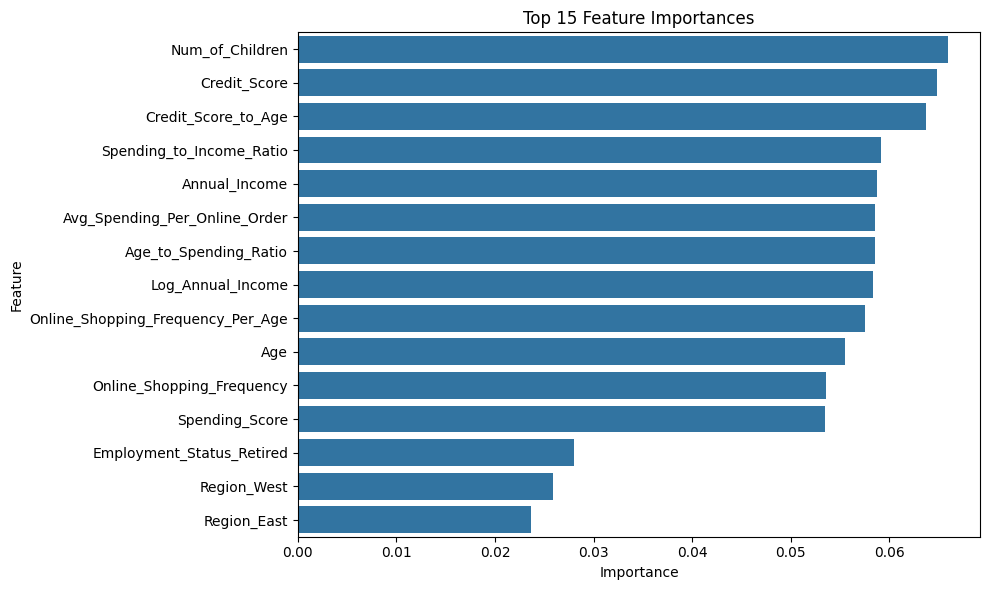

In [410]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, f1_score, precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

data = df.copy()

data['Spending_to_Income_Ratio'] = data['Spending_Score'] / data['Annual_Income']
data['Age_to_Spending_Ratio'] = data['Age'] / (data['Spending_Score'] + 1)
data['Avg_Spending_Per_Online_Order'] = data['Spending_Score'] / (data['Online_Shopping_Frequency'] + 1)
data['Online_Shopping_Frequency_Per_Age'] = data['Online_Shopping_Frequency'] / data['Age']
data['Log_Annual_Income'] = np.log1p(data['Annual_Income'])
data['Low_Credit_Score'] = (data['Credit_Score'] < 400).astype(int)
data['Credit_Score_to_Age'] = data['Credit_Score'] / data['Age']

X = data.drop(columns=['Target'])
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = ['Age', 'Annual_Income', 'Spending_Score', 'Credit_Score', 'Online_Shopping_Frequency', 'Num_of_Children', 'Spending_to_Income_Ratio', 'Age_to_Spending_Ratio', 'Avg_Spending_Per_Online_Order', 'Online_Shopping_Frequency_Per_Age', 'Log_Annual_Income', 'Low_Credit_Score', 'Credit_Score_to_Age']

categorical_features = ['Gender', 'Region', 'Marital_Status', 'Employment_Status']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_imb_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report (Default Threshold 0.5):")
print(classification_report(y_test, y_pred))
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))

print("\nConfusion Matrix (Optimal Threshold):")
print(confusion_matrix(y_test, y_pred_optimal))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Average Precision Score:", average_precision_score(y_test, y_pred_proba))
print("Optimal Threshold:", optimal_threshold)

rf_model = best_model.named_steps['randomforestclassifier']
onehot_columns = best_model.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_columns)
feature_importances = pd.DataFrame({'Feature': all_features, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'votingclassifier__rf__max_features': 'sqrt', 'votingclassifier__rf__n_estimators': 100, 'votingclassifier__xgb__learning_rate': 0.01, 'votingclassifier__xgb__max_depth': 3}

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.92      0.00      0.01      4173
           1       0.30      1.00      0.47      1827

    accuracy                           0.31      6000
   macro avg       0.61      0.50      0.24      6000
weighted avg       0.73      0.31      0.15      6000


Confusion Matrix:
[[  11 4162]
 [   1 1826]]

ROC-AUC Score: 0.4931635605177339
Average Precision Score: 0.3008311769794135
Optimal Threshold: 0.3277147244166216


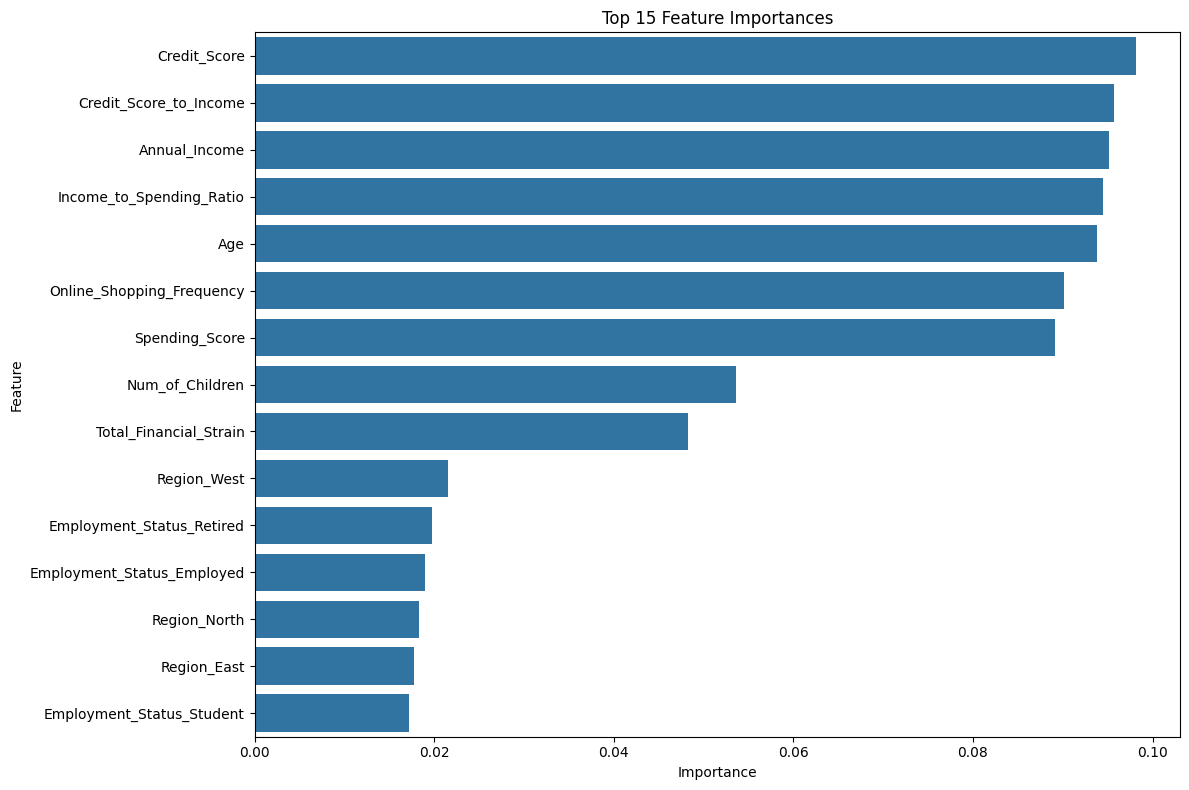

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, f1_score, precision_recall_curve, 
                           average_precision_score, make_scorer)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

data = df.copy()

data['Income_to_Spending_Ratio'] = data['Annual_Income'] / (data['Spending_Score'] + 1)
data['Credit_Score_to_Income'] = data['Credit_Score'] / (data['Annual_Income'] / 1000)
data['Is_High_Spender'] = (data['Spending_Score'] > 75).astype(int)
data['Total_Financial_Strain'] = data['Num_of_Children'] * 0.5 + (data['Marital_Status'].isin(['Divorced', 'Widowed'])).astype(int)

X = data.drop(columns=['Target'])
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = ['Age', 'Annual_Income', 'Spending_Score', 
                  'Credit_Score', 'Online_Shopping_Frequency', 
                  'Num_of_Children', 'Income_to_Spending_Ratio',
                  'Credit_Score_to_Income', 'Total_Financial_Strain']
categorical_features = ['Gender', 'Region', 'Marital_Status', 
                       'Employment_Status', 'Is_High_Spender']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

xgb = XGBClassifier(random_state=42, eval_metric='aucpr',
                   scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))

cat = CatBoostClassifier(random_state=42, auto_class_weights='Balanced',
                        verbose=0, thread_count=-1)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

ensemble = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('cat', cat),
    ('rf', rf)
], voting='soft')

pipeline = make_imb_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    ensemble
)

param_grid = {
    'votingclassifier__xgb__max_depth': [3, 5],
    'votingclassifier__xgb__learning_rate': [0.01, 0.1],
    'votingclassifier__rf__n_estimators': [100, 200],
    'votingclassifier__rf__max_features': ['sqrt', 0.5]
}

scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring=scorer, 
    n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Average Precision Score:", average_precision_score(y_test, y_pred_proba))
print("Optimal Threshold:", optimal_threshold)

try:
    rf_model = best_model.named_steps['votingclassifier'].estimators_[2]
    importances = rf_model.feature_importances_
    
    onehot_columns = best_model.named_steps['columntransformer']\
                      .named_transformers_['cat'].named_steps['onehot']\
                      .get_feature_names_out(categorical_features)
    all_features = numeric_features + list(onehot_columns)
    
    feature_importances = pd.DataFrame({'Feature': all_features, 
                                       'Importance': importances})
    feature_importances = feature_importances.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', 
                data=feature_importances.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importance visualization error:", e)

errors = X_test.copy()
errors['True'] = y_test
errors['Predicted'] = y_pred_optimal
errors['Probability'] = y_pred_proba